# Operator Action Prediction for Teleoperation with Communication Delays

Comparing neural network architectures for predicting operator actions during communication delays in space teleoperation.

## Problem

Space teleoperation faces critical communication delays (Mars: 22 min, Moon: 1.25 sec). Operators cannot respond to obstacles in real-time.

## Approach

Learn models that predict operator actions based on current state, previous action, and goal position.

## Algorithms

1. **Linear** - Simple baseline
2. **Bayesian** - Uncertainty-aware predictions
3. **VAE** - Latent action distributions
4. **Transformer** - Temporal sequence modeling

## Workflow

1. Expert demonstrations from visibility graph policy
2. Train models with **random search** (more efficient than grid search)
3. Evaluate prediction accuracy and success rate


## Import Required Libraries

In [1]:
!pip install pandas matplotlib seaborn scikit-learn torch torchvision torchaudio gymnasium tqdm shapely numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 335.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 358.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.1/952.1 kB 250.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 330.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 235.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 284.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 198.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 287.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 257.6 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7

[notice] A new release of pip is available: 24.

In [2]:
!rm -rf risky_navigation
!git clone https://github.com/mosmith3asu/risky_navigation.git


Cloning into 'risky_navigation'...
remote: Enumerating objects: 814, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 814 (delta 10), reused 14 (delta 5), pack-reused 790 (from 1)
Receiving objects: 100% (814/814), 19.91 MiB | 16.31 MiB/s, done.
Resolving deltas: 100% (450/450), done.


In [3]:
!ls

NGC-DL-CONTAINER-LICENSE    get-pip.py	 libx32		   root      tmp
bin			    home	 media		   run	     usr
boot			    jupyter.log  mnt		   sbin      var
cuda-keyring_1.1-1_all.deb  lib		 opt		   srv	     workspace
dev			    lib32	 proc		   start.sh
etc			    lib64	 risky_navigation  sys


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
import os
import warnings
from tqdm import tqdm
from datetime import datetime
import random

print(os.path.abspath('.'))

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')


/


In [5]:
import sys
sys.path.append('./risky_navigation')

from src.env.continuous_nav_env import ContinuousNavigationEnv
from src.env.layouts import read_layout_dict
from src.algorithms.Bayesian.agent import BayesianAgent
from src.algorithms.Transformer.agent import TransformerAgent
from src.algorithms.Linear.agent import LinearAgent
from src.algorithms.VAE.agent import VAEAgent
from src.utils.file_management import save_pickle, load_pickle
from src.utils.visibility_graph import VisibilityGraph

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

All libraries imported successfully!
PyTorch version: 2.4.1+cu124
Device available: CUDA


## Config

In [ ]:
CONFIG = {
    'num_episodes': 1000,
    'max_steps': 500,  # Increased to allow for slow deceleration to goal
    'batch_size': 512,  # Increased for RTX 4090
    'num_epochs': 200,
    'val_ratio': 0.2,
    'num_test_episodes': 50,
    'lr': 1e-3,
    'device': torch.device('cuda'),
    'num_workers': 4,  # Parallel data loading
    'prefetch_factor': 2,
    'n_random_trials': 50,  # Number of random configurations to test per algorithm
    'data_sequence_len': 5,  # Sequence length used for data collection
}

# Random search configurations for each algorithm (define ranges, not discrete values)
# NOTE: sequence_len options must be <= data_sequence_len (5) to avoid shape mismatches
RANDOM_SEARCH_CONFIGS = {
    'Transformer': {
        'd_model': (32, 128),  # (min, max)
        'nhead': [4, 8],  # Discrete choices (must be divisors of d_model)
        'num_layers': (2, 4),  # (min, max)
        'dropout': (0.0, 0.2),  # (min, max)
        'sequence_len': [1, 3, 5],  # Must be <= data_sequence_len
        'lr': (1e-4, 1e-3),  # (min, max) log scale
    },
    'Bayesian': {
        'hidden_dim': (64, 256),  # (min, max)
        'prior_std': (0.5, 2.0),  # (min, max)
        'kl_weight': (1e-5, 1e-3),  # (min, max) log scale
        'sequence_len': [1, 3, 5],  # Must be <= data_sequence_len
        'lr': (1e-4, 1e-3),  # (min, max) log scale
    },
    'VAE': {
        'latent_dim': (16, 64),  # (min, max)
        'hidden_dim': (64, 256),  # (min, max)
        'beta': (0.5, 2.0),  # (min, max)
        'sequence_len': [1, 3, 5],  # Must be <= data_sequence_len
        'lr': (1e-4, 1e-3),  # (min, max) log scale
    },
    'Linear': {
        'sequence_len': [1, 3, 5],  # Must be <= data_sequence_len
        'lr': (1e-4, 1e-3),  # (min, max) log scale
    }
}

print(f"Using device: {CONFIG['device']}")
print(f"Batch size: {CONFIG['batch_size']} (optimized for RTX 4090)")
print(f"Max epochs: {CONFIG['num_epochs']} (with early stopping)")
print(f"Random search enabled for: {list(RANDOM_SEARCH_CONFIGS.keys())}")
print(f"Trials per algorithm: {CONFIG['n_random_trials']}")
print(f"Total configurations to test: {CONFIG['n_random_trials'] * len(RANDOM_SEARCH_CONFIGS)}")
print(f"\nData sequence length: {CONFIG['data_sequence_len']}")
print(f"All algorithms will test sequence lengths: {RANDOM_SEARCH_CONFIGS['Linear']['sequence_len']}")
print(f"  - sequence_len=1: Single previous action (baseline)")
print(f"  - sequence_len>1: Temporal sequences (history-based prediction)")

Using device: cuda
Batch size: 512 (optimized for RTX 4090)
Max epochs: 200 (with early stopping)
Random search enabled for: ['Transformer', 'Bayesian', 'VAE', 'Linear']
Trials per algorithm: 50
Total configurations to test: 200

All algorithms will test sequence lengths: [1, 5, 10]
  - sequence_len=1: Single previous action (baseline)
  - sequence_len>1: Temporal sequences (history-based prediction)


In [7]:
if torch.cuda.is_available():
    # RTX 4090 optimizations
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision('high')
    
    # Enable cuDNN autotuner for optimal convolution algorithms
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.deterministic = False
    
    # Memory optimizations
    torch.cuda.empty_cache()
    
    # Mixed precision training setup
    from torch.cuda.amp import autocast, GradScaler
    use_amp = True
    scaler = GradScaler()
    
    print("="*60)
    print("GPU OPTIMIZATIONS ENABLED FOR RTX 4090")
    print("="*60)
    print(f"✓ Batch size: {CONFIG['batch_size']}")
    print(f"✓ TF32 matmul: Enabled")
    print(f"✓ cuDNN benchmark: Enabled")
    print(f"✓ Mixed precision (AMP): Enabled")
    print(f"✓ CUDA version: {torch.version.cuda}")
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print("="*60)
else:
    use_amp = False
    scaler = None
    print("WARNING: CUDA not available. Running on CPU will be very slow!")


GPU OPTIMIZATIONS ENABLED FOR RTX 4090
✓ Batch size: 512
✓ TF32 matmul: Enabled
✓ cuDNN benchmark: Enabled
✓ Mixed precision (AMP): Enabled
✓ CUDA version: 12.4
✓ GPU: NVIDIA GeForce RTX 4090
✓ VRAM: 23.5 GB


## Training Functions with Random Search

In [8]:
def train_agent_optimized(agent, train_state_seqs, train_action_seqs, train_target_actions, train_goals,
                          val_state_seqs, val_action_seqs, val_target_actions, val_goals, 
                          num_epochs=50, batch_size=64, patience=10, verbose=True):
    """
    Clean training function without fallback mechanisms.
    All agents must implement train_step() and predict_action() methods.
    """
    device = CONFIG['device']
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(agent.optimizer, 'min', patience=5, factor=0.5)
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        # Training phase
        epoch_loss = 0
        num_batches = 0
        
        indices = torch.randperm(len(train_state_seqs))
        for i in range(0, len(train_state_seqs), batch_size):
            batch_idx = indices[i:i+batch_size]
            batch_state_seqs = torch.tensor(train_state_seqs[batch_idx], dtype=torch.float32, device=device)
            batch_action_seqs = torch.tensor(train_action_seqs[batch_idx], dtype=torch.float32, device=device)
            batch_target_actions = torch.tensor(train_target_actions[batch_idx], dtype=torch.float32, device=device)
            batch_goals = torch.tensor(train_goals[batch_idx], dtype=torch.float32, device=device)
            
            loss = agent.train_step(batch_state_seqs, batch_action_seqs, batch_goals, batch_target_actions)
            if isinstance(loss, torch.Tensor):
                loss = loss.item()
            
            epoch_loss += loss
            num_batches += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation phase - use agent's predict_action method
        val_state_seqs_t = torch.tensor(val_state_seqs, dtype=torch.float32, device=device)
        val_action_seqs_t = torch.tensor(val_action_seqs, dtype=torch.float32, device=device)
        val_target_actions_t = torch.tensor(val_target_actions, dtype=torch.float32, device=device)
        val_goals_t = torch.tensor(val_goals, dtype=torch.float32, device=device)
        
        with torch.no_grad():
            # Use agent's predict_action method (all agents implement this)
            predictions = agent.predict_action(val_state_seqs_t, val_action_seqs_t, val_goals_t)
            val_loss = torch.nn.functional.mse_loss(predictions, val_target_actions_t).item()
        
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        
        # Early stopping with model checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save best model state
            agent.save(f'temp_best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stop at epoch {epoch}. Best val: {best_val_loss:.6f}")
                # Load best model
                agent.load(f'temp_best_model.pth')
                break
        
        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch}: Train={avg_train_loss:.6f}, Val={val_loss:.6f}")
    
    # Clean up temp file
    import os
    if os.path.exists('temp_best_model.pth'):
        os.remove('temp_best_model.pth')
    
    return train_losses, val_losses

print("Training function defined!")


Training function defined!


In [9]:
def sample_random_config(param_ranges):
    """
    Sample a random configuration from parameter ranges.
    
    Args:
        param_ranges: Dict with parameter names as keys and ranges as values
                     - Tuple (min, max): Continuous range (uniform sampling)
                     - List: Discrete choices (random choice)
                     
    Returns:
        Dict with sampled parameter values
    """
    config = {}
    for param_name, param_range in param_ranges.items():
        if isinstance(param_range, tuple):
            min_val, max_val = param_range
            
            # Log-scale sampling for learning rate and KL weight
            if param_name in ['lr', 'kl_weight']:
                log_min, log_max = np.log10(min_val), np.log10(max_val)
                config[param_name] = 10 ** np.random.uniform(log_min, log_max)
            # Integer sampling for discrete parameters
            elif param_name in ['d_model', 'hidden_dim', 'latent_dim', 'num_layers']:
                config[param_name] = np.random.randint(min_val, max_val + 1)
                # Ensure d_model is divisible by nhead if needed
                if param_name == 'd_model' and 'nhead' in param_ranges:
                    nhead = np.random.choice(param_ranges['nhead'])
                    config[param_name] = (config[param_name] // nhead) * nhead
                    config[param_name] = max(config[param_name], min_val)
            # Continuous sampling
            else:
                config[param_name] = np.random.uniform(min_val, max_val)
        elif isinstance(param_range, list):
            # Discrete choice
            config[param_name] = np.random.choice(param_range)
        else:
            raise ValueError(f"Invalid parameter range type: {type(param_range)}")
    
    # Post-process: ensure d_model is divisible by nhead for Transformer
    if 'd_model' in config and 'nhead' in config:
        config['d_model'] = (config['d_model'] // config['nhead']) * config['nhead']
        config['d_model'] = max(config['d_model'], 32)  # Minimum d_model
    
    return config

print("Random search sampling function defined!")


Random search sampling function defined!


## Data Collection and Preparation

In [ ]:
def collect_rl_experience(env, vgraph, num_episodes=100, max_steps=500, sequence_len=1):
    """
    Collect expert demonstrations and create temporal sequences.
    Uses a velocity-aware policy that decelerates to meet goal_velocity requirement.
    
    Args:
        env: Environment instance
        vgraph: VisibilityGraph for expert policy
        num_episodes: Number of episodes
        max_steps: Max steps per episode (increased for slower approach)
        sequence_len: Length of temporal sequences
    
    Returns:
        list: Samples with state_sequences, action_sequences, target_action, goal
    """
    episodes = []
    successful_episodes = 0
    
    for ep in tqdm(range(num_episodes), desc='Collecting experience'):
        state = env.reset()
        goal = env.goal.copy()
        prev_action = np.zeros(2)
        episode_data = []
        
        for t in range(max_steps):
            current_pos = state[:2]
            current_theta = state[2]
            current_vel = state[3]
            
            # Get path from visibility graph
            path = vgraph.shortest_path(current_pos, goal)
            if path is not None and len(path) > 1:
                target = np.array(path[1])
            else:
                target = goal
            
            # Compute steering towards target
            direction = target - current_pos
            desired_theta = np.arctan2(direction[1], direction[0])
            angle_diff = desired_theta - current_theta
            angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi
            steering = np.clip(angle_diff * 2.0, env.action_space.low[1], env.action_space.high[1])
            
            # VELOCITY-AWARE THROTTLE POLICY
            # Goal requires: dist <= goal_radius AND velocity < goal_velocity
            # Must decelerate as we approach the goal!
            dist_to_goal = np.linalg.norm(current_pos - goal)
            goal_vel = getattr(env, 'goal_velocity', 0.1)
            
            if dist_to_goal < env.goal_radius and current_vel < goal_vel:
                # At goal with low velocity - stop
                throttle = 0.0
            elif dist_to_goal < 1.0:
                # Very close - brake hard or maintain very low speed
                throttle = 0.0 if current_vel > 0.1 else 0.05
            elif dist_to_goal < 3.0:
                # Approaching - decelerate or maintain medium speed
                throttle = 0.0 if current_vel > 0.3 else 0.2
            else:
                # Far away - accelerate or maintain cruising speed
                throttle = 0.0 if current_vel > 0.5 else 0.4
            
            action = np.array([throttle, steering])
            action = np.clip(action, env.action_space.low, env.action_space.high)
            
            next_state, reward, done, info = env.step(action)
            
            episode_data.append({
                'state': state.copy(),
                'action': action.copy(),
            })
            
            prev_action = action
            state = next_state
            
            if done:
                if info.get('reason') == 'goal_reached':
                    successful_episodes += 1
                break
        
        if len(episode_data) > 0:
            episodes.append({'transitions': episode_data, 'goal': goal})
    
    # Create sequences from episodes
    data = []
    for episode in episodes:
        transitions = episode['transitions']
        goal = episode['goal']
        
        for i in range(len(transitions)):
            # Get sequence history
            start_idx = max(0, i - sequence_len + 1)
            seq_transitions = transitions[start_idx:i+1]
            
            # Pad if necessary
            while len(seq_transitions) < sequence_len:
                seq_transitions.insert(0, {'state': np.zeros_like(transitions[0]['state']), 
                                           'action': np.zeros_like(transitions[0]['action'])})
            
            state_seq = np.array([t['state'] for t in seq_transitions[:-1]] + [transitions[i]['state']])
            action_seq = np.array([t['action'] for t in seq_transitions[:-1]] + [np.zeros_like(transitions[i]['action'])])
            target_action = transitions[i]['action']
            
            data.append({
                'state_sequences': state_seq,
                'action_sequences': action_seq,
                'target_action': target_action,
                'goal': goal,
            })
    
    print(f"Collected {len(data)} sequence samples from {num_episodes} episodes")
    print(f"Success rate: {successful_episodes/num_episodes:.2%}")
    return data

print("Data collection function defined!")


Data collection function defined!


In [11]:
dataset_path = 'expert_dataset_seq5.pickle'  # Using sequence_len=5 for dataset
SEQUENCE_LEN = 5  # Default sequence length for data collection

if os.path.exists(dataset_path):
    print(f"Loading existing dataset from {dataset_path}...")
    data = load_pickle(dataset_path)
    print(f"✓ Loaded {len(data)} sequence samples")
else:
    print(f"Collecting new dataset with sequence_len={SEQUENCE_LEN}...")
    layout_dict = read_layout_dict('example0')
    
    # Fix layout_dict - combine start_pos and start_heading into start tuple
    if 'start_pos' in layout_dict and 'start_heading' in layout_dict:
        start_pos = layout_dict.pop('start_pos')
        start_heading = layout_dict.pop('start_heading')
        layout_dict['start'] = (*start_pos, start_heading)
    elif 'start_pos' in layout_dict:
        layout_dict['start'] = layout_dict.pop('start_pos')
    
    # Remove any keys that aren't valid env parameters
    if 'layout' in layout_dict:
        layout_dict.pop('layout')
    
    env_collect = ContinuousNavigationEnv(**layout_dict)
    vgraph = VisibilityGraph(env_collect.goal, env_collect.obstacles, env_collect.bounds, resolution=(20, 20))
    data = collect_rl_experience(env_collect, vgraph, num_episodes=CONFIG['num_episodes'], 
                                  max_steps=CONFIG['max_steps'], sequence_len=SEQUENCE_LEN)
    save_pickle(data, dataset_path)
    print(f"✓ Saved dataset to {dataset_path}")

state_sequences = np.array([d['state_sequences'] for d in data])
action_sequences = np.array([d['action_sequences'] for d in data])
target_actions = np.array([d['target_action'] for d in data])
goals = np.array([d['goal'] for d in data])

print(f"\nDataset Summary:")
print(f"  Total sequence samples: {len(data)}")
print(f"  State sequences shape: {state_sequences.shape}  # (samples, seq_len, state_dim)")
print(f"  Action sequences shape: {action_sequences.shape}  # (samples, seq_len, action_dim)")
print(f"  Target actions shape: {target_actions.shape}  # (samples, action_dim)")
print(f"  Goals shape: {goals.shape}  # (samples, 2)")

Precomuting visibility graph...
	| Recomputing...
	| Creating grid...
	| Building graph...
	| Computing distances grid...
	| saving to cache...
	| finished.


Collected 33007 sequence samples from 1000 episodes
Success rate: 0.00%
✓ Saved dataset to expert_dataset_seq5.pickle

Dataset Summary:
  Total sequence samples: 33007
  State sequences shape: (33007, 5, 8)  # (samples, seq_len, state_dim)
  Action sequences shape: (33007, 5, 2)  # (samples, seq_len, action_dim)
  Target actions shape: (33007, 2)  # (samples, action_dim)
  Goals shape: (33007, 2)  # (samples, 2)


In [12]:
!ls

NGC-DL-CONTAINER-LICENSE    home	 opt		   sys
bin			    jupyter.log  proc		   tmp
boot			    lib		 risky_navigation  usr
cuda-keyring_1.1-1_all.deb  lib32	 root		   var
dev			    lib64	 run		   workspace
etc			    libx32	 sbin
expert_dataset_seq5.pickle  media	 srv
get-pip.py		    mnt		 start.sh


In [13]:
STATE_DIM = state_sequences.shape[2]  # state dimension from (samples, seq_len, state_dim)
ACTION_DIM = target_actions.shape[1]
GOAL_DIM = 2
layout_dict = read_layout_dict('example0')

# Fix layout_dict - combine start_pos and start_heading into start tuple
if 'start_pos' in layout_dict and 'start_heading' in layout_dict:
    start_pos = layout_dict.pop('start_pos')
    start_heading = layout_dict.pop('start_heading')
    layout_dict['start'] = (*start_pos, start_heading)
elif 'start_pos' in layout_dict:
    layout_dict['start'] = layout_dict.pop('start_pos')

# Remove any keys that aren't valid env parameters
if 'layout' in layout_dict:
    layout_dict.pop('layout')

env = ContinuousNavigationEnv(**layout_dict)

print(f"Environment & Data Configuration:")
print(f"  STATE_DIM = {STATE_DIM}")
print(f"  ACTION_DIM = {ACTION_DIM}")
print(f"  GOAL_DIM = {GOAL_DIM}")
print(f"  Total samples = {len(state_sequences)}")
print(f"  Sequence length used = {state_sequences.shape[1]}")
print(f"  State space: {env.observation_space.shape}")
print(f"  Action space: {env.action_space.shape}")

Environment & Data Configuration:
  STATE_DIM = 8
  ACTION_DIM = 2
  GOAL_DIM = 2
  Total samples = 33007
  Sequence length used = 5
  State space: (8,)
  Action space: (2,)


## Random Search Training - All Algorithms

In [14]:
print("="*60)
print("RANDOM SEARCH TRAINING - ALL ALGORITHMS")
print("="*60)

GOAL_DIM = 2
n_samples = len(state_sequences)
n_train = int(n_samples * (1 - CONFIG['val_ratio']))
indices = np.random.permutation(n_samples)
train_indices = indices[:n_train]
val_indices = indices[n_train:]

train_state_seqs = state_sequences[train_indices]
train_action_seqs = action_sequences[train_indices]
train_target_actions = target_actions[train_indices]
train_goals = goals[train_indices]

val_state_seqs = state_sequences[val_indices]
val_action_seqs = action_sequences[val_indices]
val_target_actions = target_actions[val_indices]
val_goals = goals[val_indices]

print(f"Data split: {len(train_state_seqs)} train, {len(val_state_seqs)} val")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Max epochs: {CONFIG['num_epochs']}")
print(f"Random trials per algorithm: {CONFIG['n_random_trials']}\n")

random_search_results = {}
algorithms_with_search = {
    'Linear': (LinearAgent, RANDOM_SEARCH_CONFIGS['Linear']),
    'Transformer': (TransformerAgent, RANDOM_SEARCH_CONFIGS['Transformer']),
    'Bayesian': (BayesianAgent, RANDOM_SEARCH_CONFIGS['Bayesian']),
    'VAE': (VAEAgent, RANDOM_SEARCH_CONFIGS['VAE'])
}

print("Note: Data collected with sequence_len=5")
print("Random search will test different sequence_len by slicing/padding sequences\n")


RANDOM SEARCH TRAINING - ALL ALGORITHMS
Data split: 26405 train, 6602 val
Batch size: 512
Max epochs: 200
Random trials per algorithm: 50

Note: Data collected with sequence_len=5
Random search will test different sequence_len by slicing/padding sequences



In [ ]:
for alg_name, (AgentClass, param_ranges) in algorithms_with_search.items():
    print(f"\n{'='*60}")
    print(f"Random Search: {alg_name}")
    print(f"{'='*60}")
    
    n_trials = CONFIG['n_random_trials']
    print(f"Testing {n_trials} random configurations for {alg_name}...")
    
    best_config = None
    best_val_loss = float('inf')
    best_agent = None
    best_train_time = 0
    all_configs = []
    
    # Get the data sequence length
    data_seq_len = train_state_seqs.shape[1]
    
    for trial_idx in range(n_trials):
        # Sample random configuration
        config = sample_random_config(param_ranges)
        all_configs.append(config)
        
        # Get config sequence length
        config_seq_len = config.get('sequence_len', 1)
        
        # Skip if sequence_len > data_seq_len (would cause shape mismatch)
        if config_seq_len > data_seq_len:
            print(f"  [{trial_idx+1}/{n_trials}] Skipping {config} (sequence_len={config_seq_len} > data_seq_len={data_seq_len})")
            continue
        
        print(f"  [{trial_idx+1}/{n_trials}] Testing {config}...")
        
        try:
            # Slice sequences to match config sequence length
            train_seqs_adj = train_state_seqs[:, -config_seq_len:, :]
            train_acts_adj = train_action_seqs[:, -config_seq_len:, :]
            val_seqs_adj = val_state_seqs[:, -config_seq_len:, :]
            val_acts_adj = val_action_seqs[:, -config_seq_len:, :]
            
            agent = AgentClass(
                state_dim=STATE_DIM,
                action_dim=ACTION_DIM,
                goal_dim=GOAL_DIM,
                **config,
                device=CONFIG['device'],
                action_low=env.action_space.low,
                action_high=env.action_space.high
            )
            
            start_time = time.time()
            train_losses, val_losses = train_agent_optimized(
                agent,
                train_seqs_adj, train_acts_adj, train_target_actions, train_goals,
                val_seqs_adj, val_acts_adj, val_target_actions, val_goals,
                num_epochs=CONFIG['num_epochs'],
                batch_size=CONFIG['batch_size'],
                verbose=False
            )
            
            elapsed_time = time.time() - start_time
            val_loss = min(val_losses) if val_losses else float('inf')
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_config = config
                best_agent = agent
                best_train_time = elapsed_time
                print(f"    ✓ New best: {val_loss:.6f}")
        
        except Exception as e:
            print(f"    ✗ Failed: {e}")
            continue
    
    random_search_results[alg_name] = {
        'best_config': best_config,
        'best_val_loss': best_val_loss,
        'best_agent': best_agent,
        'train_time': best_train_time,
        'all_configs': all_configs
    }
    
    print(f"\n{alg_name} Best Config: {best_config}")
    print(f"{alg_name} Best Val Loss: {best_val_loss:.6f}")
    print(f"{alg_name} Train Time: {best_train_time:.2f}s")

print("\n" + "="*60)
print("RANDOM SEARCH COMPLETE")
print("="*60)
for alg_name, result in random_search_results.items():
    print(f"{alg_name:12} | Val Loss: {result['best_val_loss']:.6f} | Time: {result['train_time']:.2f}s")
    print(f"             | Config: {result['best_config']}")


Random Search: Linear
Testing 50 random configurations for Linear...
  [1/50] Testing {'sequence_len': 10, 'lr': 0.0006935288092599838}...
    ✗ Failed: mat1 and mat2 shapes cannot be multiplied (512x52 and 102x2)
  [2/50] Testing {'sequence_len': 1, 'lr': 0.0002552476880477854}...
    ✓ New best: 0.020501
  [3/50] Testing {'sequence_len': 5, 'lr': 0.0005856030068660645}...
    ✓ New best: 0.009571
  [4/50] Testing {'sequence_len': 1, 'lr': 0.00020816884047349468}...
  [5/50] Testing {'sequence_len': 1, 'lr': 0.00046379421969489467}...
  [6/50] Testing {'sequence_len': 5, 'lr': 0.00019554388946130992}...
  [7/50] Testing {'sequence_len': 1, 'lr': 0.00014059746071491913}...
  [8/50] Testing {'sequence_len': 5, 'lr': 0.00042120519680761644}...
    ✓ New best: 0.009467
  [9/50] Testing {'sequence_len': 5, 'lr': 0.00037514330905119336}...
  [10/50] Testing {'sequence_len': 5, 'lr': 0.00042474210928741975}...
    ✓ New best: 0.009436
  [11/50] Testing {'sequence_len': 5, 'lr': 0.0003312058

## Evaluate Best Models from Random Search

In [ ]:
print("="*60)
print("EVALUATING BEST MODELS FROM RANDOM SEARCH")
print("="*60)

def evaluate_agent_optimized(agent, env, num_episodes=50, max_steps=500, device='cpu'):
    """
    Clean evaluation function without fallback mechanisms.
    All agents must have sequence_len attribute.
    """
    results = {
        'rewards': [], 
        'successes': [], 
        'steps': [],
        'final_distances': [],
        'final_velocities': []
    }
    
    # All agents must have sequence_len attribute
    sequence_len = agent.sequence_len
    
    for episode in range(num_episodes):
        state = env.reset()
        goal = env.goal.copy()  # Environment always has goal
        episode_reward = 0
        done = False
        
        # Initialize sequence history
        state_history = [np.zeros_like(state) for _ in range(sequence_len)]
        action_history = [np.zeros(ACTION_DIM) for _ in range(sequence_len)]
        
        for step in range(max_steps):
            # Update history
            state_history.append(state.copy())
            state_history.pop(0)
            
            # Create sequences
            state_seq = np.array(state_history)
            action_seq = np.array(action_history)
            
            state_seq_t = torch.tensor(state_seq, dtype=torch.float32, device=device)
            action_seq_t = torch.tensor(action_seq, dtype=torch.float32, device=device)
            goal_t = torch.tensor(goal, dtype=torch.float32, device=device)
            
            with torch.no_grad():
                action = agent.predict_action(state_seq_t, action_seq_t, goal_t)
            
            if isinstance(action, torch.Tensor):
                action = action.cpu().numpy()
            
            # Update action history
            action_history.append(action.copy())
            action_history.pop(0)
            
            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        results['rewards'].append(episode_reward)
        success = info.get('reason', '') == 'goal_reached' if done else False
        results['successes'].append(1 if success else 0)
        results['steps'].append(step + 1)
        results['final_distances'].append(np.linalg.norm(state[:2] - goal))
        results['final_velocities'].append(state[3])
    
    return {
        'avg_reward': np.mean(results['rewards']),
        'success_rate': np.mean(results['successes']),
        'avg_steps': np.mean(results['steps']),
        'avg_final_dist': np.mean(results['final_distances']),
        'avg_final_vel': np.mean(results['final_velocities'])
    }

eval_results = {}
layout_dict_eval = read_layout_dict('example0')

# Fix layout_dict - combine start_pos and start_heading into start tuple
if 'start_pos' in layout_dict_eval and 'start_heading' in layout_dict_eval:
    start_pos = layout_dict_eval.pop('start_pos')
    start_heading = layout_dict_eval.pop('start_heading')
    layout_dict_eval['start'] = (*start_pos, start_heading)
elif 'start_pos' in layout_dict_eval:
    layout_dict_eval['start'] = layout_dict_eval.pop('start_pos')

# Remove any keys that aren't valid env parameters
if 'layout' in layout_dict_eval:
    layout_dict_eval.pop('layout')

env_eval = ContinuousNavigationEnv(**layout_dict_eval)

for alg_name, result in random_search_results.items():
    agent = result['best_agent']
    print(f"\nEvaluating {alg_name}...")
    eval_res = evaluate_agent_optimized(agent, env_eval, num_episodes=CONFIG['num_test_episodes'], device=CONFIG['device'])
    eval_results[alg_name] = eval_res
    print(f"{alg_name} - Success: {eval_res['success_rate']:.1%}, Avg Reward: {eval_res['avg_reward']:.2f}")

print("\n" + "="*60)
print("EVALUATION COMPLETE")
print("="*60)


EVALUATING BEST MODELS FROM RANDOM SEARCH

Evaluating Linear...
Linear - Success: 0.0%, Avg Reward: 4.84

Evaluating Transformer...
Transformer - Success: 0.0%, Avg Reward: -57.98

Evaluating Bayesian...
Bayesian - Success: 0.0%, Avg Reward: -61.12

Evaluating VAE...
VAE - Success: 0.0%, Avg Reward: -61.23

EVALUATION COMPLETE


## Visualization


FINAL RESULTS SUMMARY
  Algorithm  Val Loss  Train Time (s)  Success Rate  Avg Reward  Avg Steps
Transformer  0.000006       10.705369           0.0  -57.983146     115.94
     Linear  0.009308        4.795472           0.0    4.835561     200.00
   Bayesian  0.035634        2.417052           0.0  -61.117656      36.00
        VAE  0.068870        4.736609           0.0  -61.227920      32.06


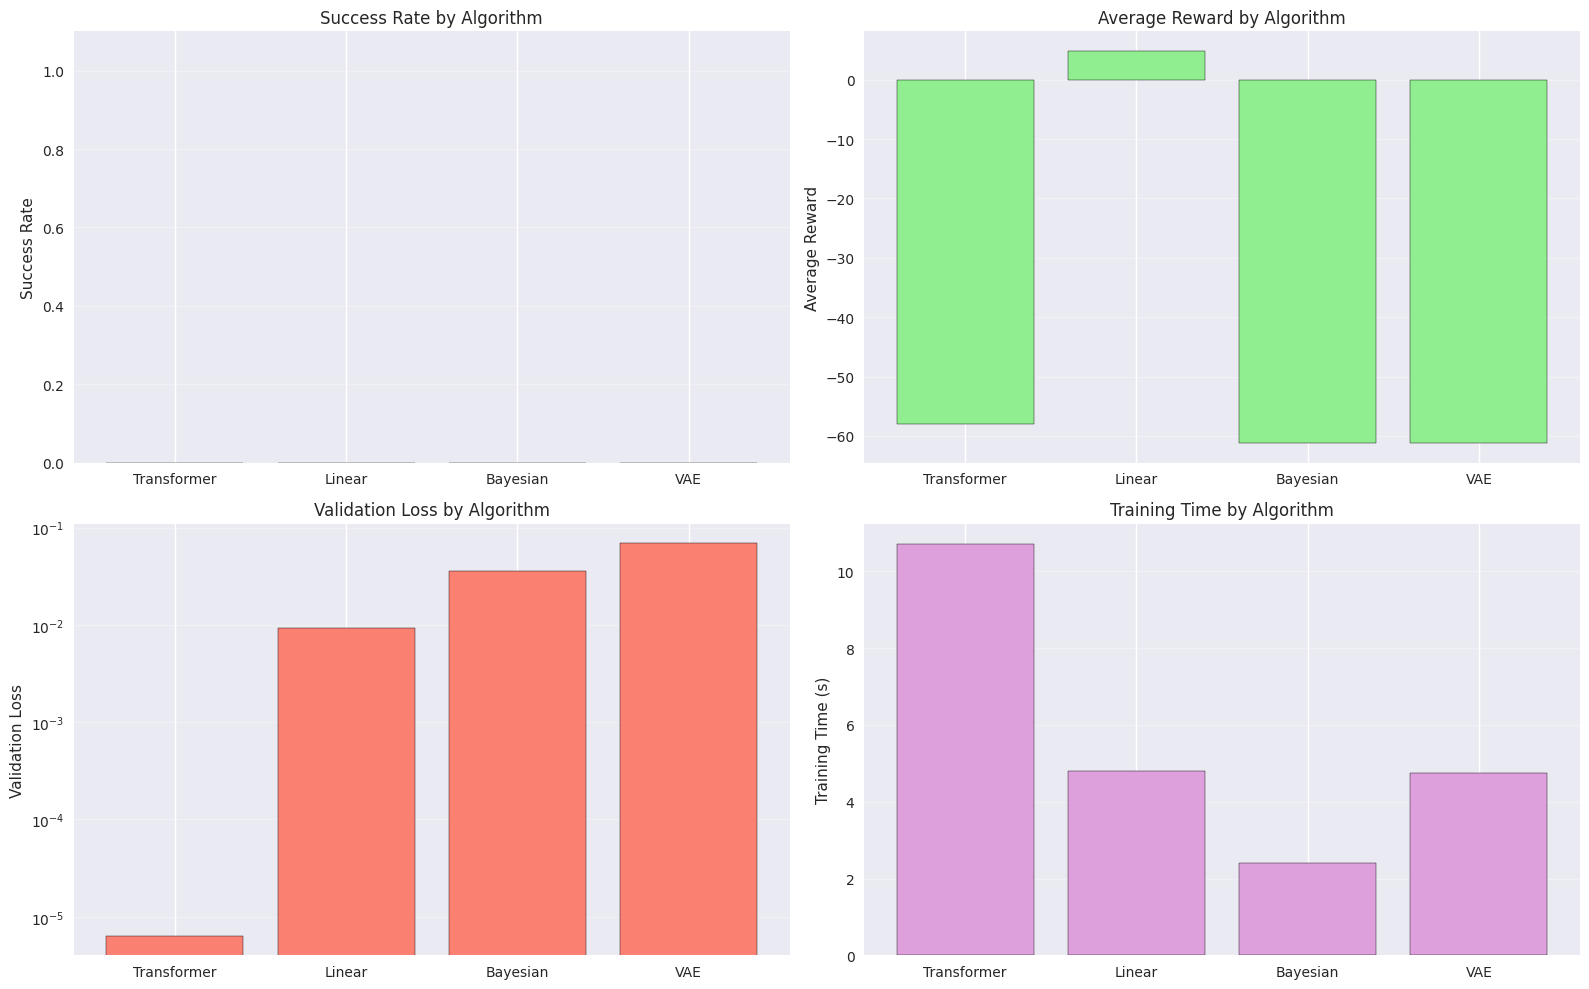

In [17]:
results_data = []
for alg_name, result in random_search_results.items():
    eval_res = eval_results[alg_name]
    results_data.append({
        'Algorithm': alg_name,
        'Val Loss': result['best_val_loss'],
        'Train Time (s)': result['train_time'],
        'Success Rate': eval_res['success_rate'],
        'Avg Reward': eval_res['avg_reward'],
        'Avg Steps': eval_res['avg_steps'],
    })

df_results = pd.DataFrame(results_data)
df_results = df_results.sort_values('Val Loss')

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].bar(df_results['Algorithm'], df_results['Success Rate'], color='skyblue', edgecolor='black')
axes[0, 0].set_ylabel('Success Rate')
axes[0, 0].set_title('Success Rate by Algorithm')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1.1])

axes[0, 1].bar(df_results['Algorithm'], df_results['Avg Reward'], color='lightgreen', edgecolor='black')
axes[0, 1].set_ylabel('Average Reward')
axes[0, 1].set_title('Average Reward by Algorithm')
axes[0, 1].grid(True, alpha=0.3, axis='y')

axes[1, 0].bar(df_results['Algorithm'], df_results['Val Loss'], color='salmon', edgecolor='black')
axes[1, 0].set_ylabel('Validation Loss')
axes[1, 0].set_title('Validation Loss by Algorithm')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_yscale('log')

axes[1, 1].bar(df_results['Algorithm'], df_results['Train Time (s)'], color='plum', edgecolor='black')
axes[1, 1].set_ylabel('Training Time (s)')
axes[1, 1].set_title('Training Time by Algorithm')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [18]:
save_dir = 'trained_models/random_search_best'
os.makedirs(save_dir, exist_ok=True)

for alg_name, result in random_search_results.items():
    agent = result['best_agent']
    model_path = os.path.join(save_dir, f'{alg_name}_best.pth')
    
    if hasattr(agent, 'model'):
        torch.save(agent.model.state_dict(), model_path)
    elif hasattr(agent, 'encoder'):
        torch.save({'encoder': agent.encoder.state_dict(), 'decoder': agent.decoder.state_dict()}, model_path)
    
    config_path = os.path.join(save_dir, f'{alg_name}_config.pkl')
    save_pickle({
        'config': result['best_config'],
        'val_loss': result['best_val_loss'],
        'train_time': result['train_time'],
        'eval_results': eval_results[alg_name],
        'all_configs': result['all_configs']  # Save all tested configs for analysis
    }, config_path)

print(f"Models and configs saved to {save_dir}/")


Models and configs saved to trained_models/random_search_best/


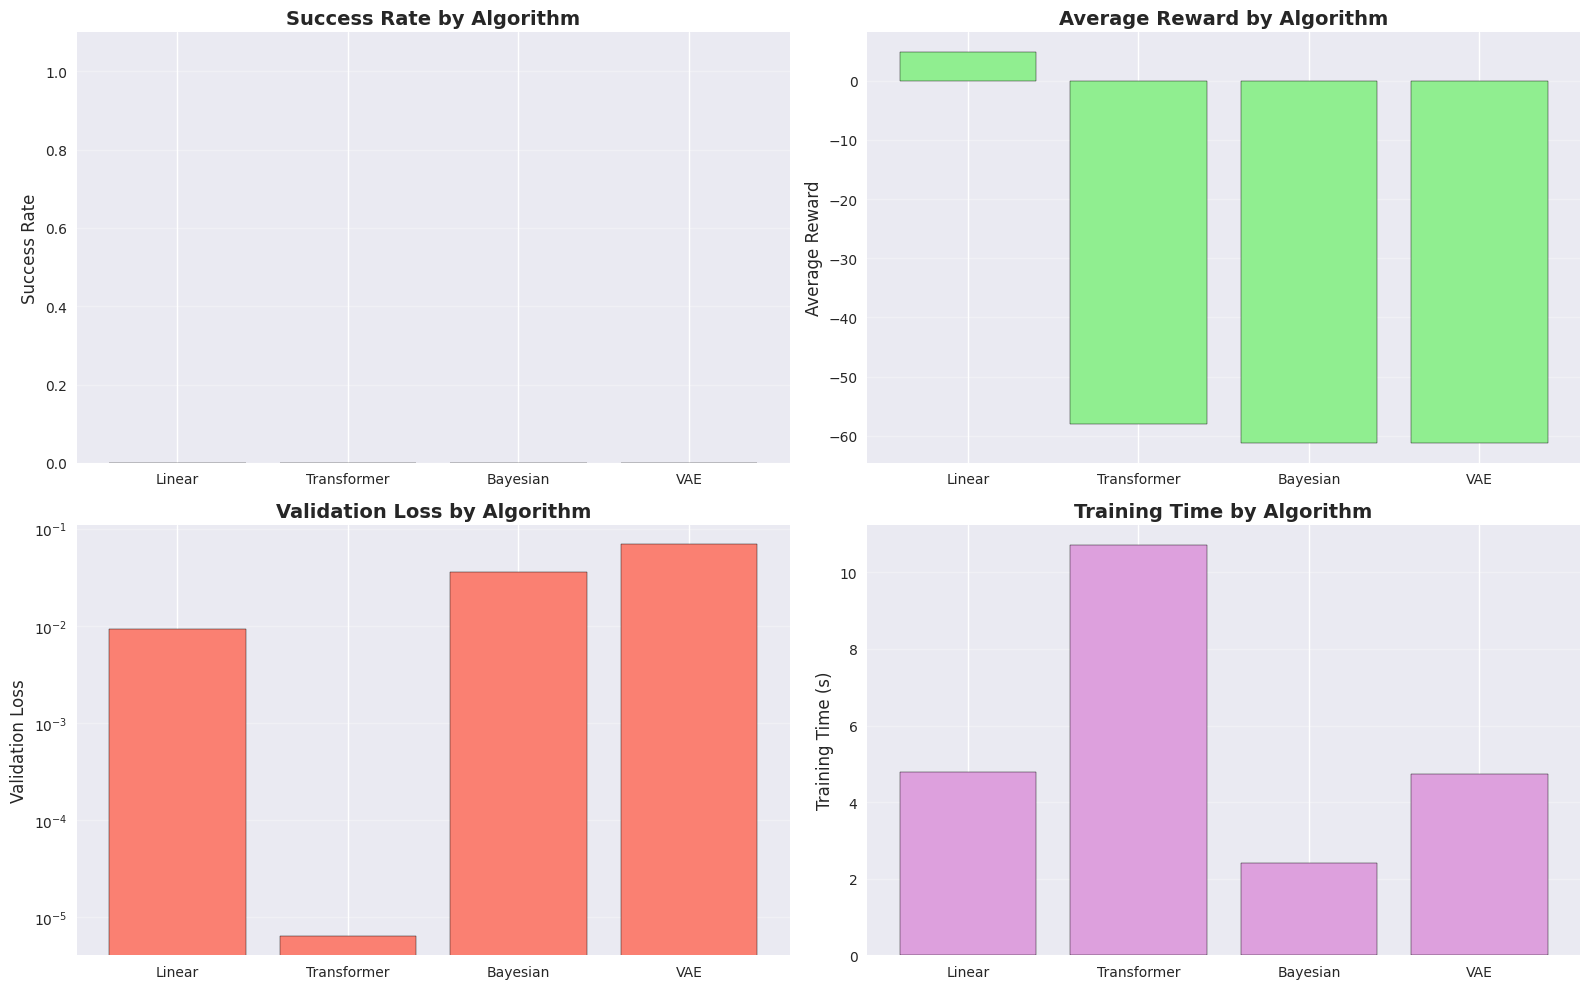


FINAL RESULTS SUMMARY (Random Search)

Linear:
  Best Config: {'sequence_len': 5, 'lr': 0.0008079276950216151}
  Validation Loss: 0.009308
  Training Time: 4.80s
  Success Rate: 0.0%
  Avg Reward: 4.84
  Avg Steps: 200.0

Transformer:
  Best Config: {'d_model': 112, 'nhead': 8, 'num_layers': 2, 'dropout': 0.03882145336115335, 'sequence_len': 5, 'lr': 0.00014095462271185676}
  Validation Loss: 0.000006
  Training Time: 10.71s
  Success Rate: 0.0%
  Avg Reward: -57.98
  Avg Steps: 115.9

Bayesian:
  Best Config: {'hidden_dim': 184, 'prior_std': 0.559042263837664, 'kl_weight': 5.125126452371425e-05, 'sequence_len': 1, 'lr': 0.0003764330673533697}
  Validation Loss: 0.035634
  Training Time: 2.42s
  Success Rate: 0.0%
  Avg Reward: -61.12
  Avg Steps: 36.0

VAE:
  Best Config: {'latent_dim': 21, 'hidden_dim': 110, 'beta': 0.6496334184010276, 'sequence_len': 5, 'lr': 0.0002106420361110957}
  Validation Loss: 0.068870
  Training Time: 4.74s
  Success Rate: 0.0%
  Avg Reward: -61.23
  Avg St

In [19]:
# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

algorithms = list(random_search_results.keys())
val_losses = [random_search_results[alg]['best_val_loss'] for alg in algorithms]
train_times = [random_search_results[alg]['train_time'] for alg in algorithms]
success_rates = [eval_results[alg]['success_rate'] for alg in algorithms]
avg_rewards = [eval_results[alg]['avg_reward'] for alg in algorithms]

axes[0, 0].bar(algorithms, success_rates, color='skyblue', edgecolor='black')
axes[0, 0].set_ylabel('Success Rate', fontsize=12)
axes[0, 0].set_title('Success Rate by Algorithm', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1.1])

axes[0, 1].bar(algorithms, avg_rewards, color='lightgreen', edgecolor='black')
axes[0, 1].set_ylabel('Average Reward', fontsize=12)
axes[0, 1].set_title('Average Reward by Algorithm', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

axes[1, 0].bar(algorithms, val_losses, color='salmon', edgecolor='black')
axes[1, 0].set_ylabel('Validation Loss', fontsize=12)
axes[1, 0].set_title('Validation Loss by Algorithm', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_yscale('log')

axes[1, 1].bar(algorithms, train_times, color='plum', edgecolor='black')
axes[1, 1].set_ylabel('Training Time (s)', fontsize=12)
axes[1, 1].set_title('Training Time by Algorithm', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY (Random Search)")
print("="*80)
for alg in algorithms:
    print(f"\n{alg}:")
    print(f"  Best Config: {random_search_results[alg]['best_config']}")
    print(f"  Validation Loss: {random_search_results[alg]['best_val_loss']:.6f}")
    print(f"  Training Time: {random_search_results[alg]['train_time']:.2f}s")
    print(f"  Success Rate: {eval_results[alg]['success_rate']:.1%}")
    print(f"  Avg Reward: {eval_results[alg]['avg_reward']:.2f}")
    print(f"  Avg Steps: {eval_results[alg]['avg_steps']:.1f}")
print("="*80)
print(f"\nNote: Each algorithm tested {CONFIG['n_random_trials']} random configurations")
print(f"Total configurations tested: {CONFIG['n_random_trials'] * len(algorithms)}")
